# Physics Informed Neural Networks

This notebook provides a set of utilities allowing to compute the power flow under the physics informed graph neural network

### Prerequisites
To be able to use this notebook and the corresponding functions, you should install the `torch-geometric` package

In [ ]:
!pip install torch-geometric

In [1]:
import matplotlib.pyplot as plt
import torch
from lips.benchmark.powergridBenchmark import PowerGridBenchmark
from utils.graph_utils import prepare_dataset

In [2]:
# Use some required pathes
import pathlib
DATA_PATH = pathlib.Path().resolve() / "input_data_local" / "lips_case14_sandbox"
BENCH_CONFIG_PATH = pathlib.Path().resolve() / "configs" / "benchmarks" / "lips_case14_sandbox.ini"

Download the dataset, if it has not been already done. The dataset used for the purpose of this notebook is generated using DC approximation solver and is only for illustration purpose.

In [1]:
# Commands required for downloading the DC dataset

Load the benchmark. Here, we select a benchmark (`Benchmark_DC`) where the data are generated using DC (Direct Current) approximation solver. It is only for illustration purpose and the participants should use the competition benchmark and dataset.

In [3]:
benchmark = PowerGridBenchmark(benchmark_name="Benchmark_DC",
                               benchmark_path=DATA_PATH,
                               load_data_set=True,
                               log_path=None,
                               config_path=BENCH_CONFIG_PATH,
                              )

In [4]:
# Verify the dataset sizes
print(benchmark.train_dataset.size)
print(benchmark.val_dataset.size)
print(benchmark._test_dataset.size)
print(benchmark._test_ood_topo_dataset.size)

100000
10000
10000
10000


### Prepare the dataset

In order to use a Physics Informed Graph Neural Network, the dataset should be prepared and structured correctly. We provide a set of functions in `utils/graph_utils.py` which help to structure the data as graph and to create corresponding data loaders. This is based on pytorch geometric dependence which should be installed to be able to use the following commands. 

To install pytorch geometric library, you could use following command.
```command
! pip install torch-geometric
```

By calling the `prepare_dataset` function, a set of functions will be called automatically to create the final data loaders for each of `train`, `validation`, `test` and `test_ood` datasets.

In [5]:
device = torch.device("cuda:0")
train_loader, val_loader, test_loader, test_ood_loader = prepare_dataset(benchmark=benchmark, batch_size=512, device=device)

*******Train dataset*******
Train data size: 100000


  0%|          | 0/4 [00:00<?, ?it/s]

*******Validation dataset*******
Validation data size: 10000


  0%|          | 0/4 [00:00<?, ?it/s]

*******Test dataset*******
Test data size : 10000


  0%|          | 0/4 [00:00<?, ?it/s]

*******OOD dataset*******
OOD data size: 10000


  0%|          | 0/4 [00:00<?, ?it/s]

Lets have a closer look at a batch of data:

In [6]:
batch = next(iter(test_loader))

In [7]:
batch

DataBatch(x=[7168, 2], edge_index=[2, 26624], edge_attr=[26624], y=[7168, 1], edge_index_no_diag=[2, 19456], edge_attr_no_diag=[19456], ybus=[7168, 14], batch=[7168], ptr=[513])

As we can see here, a batch is composed of following elements (some of the elements could not be used by the model):

- x : is the set of features at the nodes of the graph (`prod_p` and `load_p` in this specific case);
- edge_index : is the pytorch geometric way to create the connections among nodes (works as an adjacency matrix).;
- edge_attributes : the attributes on each edge connecting a pair of nodes (admittance values);
- y : corresponds to the targets at each node of the graph which should be predicted by the model (in this case the target is only the voltage angles from which the active powers could be inferred);
- edge_index_no_diag : is same as edge_index by removing the diagonal elements.
- edge_attr_no_diag : is same as edge_attr by removing the diagonal elements.
- ybus : is the admittance matrix in its classic form.
- batch and ptr are pytorch geometric specific parameters. 

## Create a physics informed GNN
This GNN is not trainable. Each layer can be seen as one step optimization of power flow equation.

In [8]:
import torch
from utils.graph_utils import GPGmodel_without_NN

device = torch.device("cuda:0")
gpg_model_wo_nn = GPGmodel_without_NN(num_gnn_layers=100, device=device)
gpg_model_wo_nn.to(device)

GPGmodel_without_NN(
  (input_layer): GPGinput_without_NN()
  (lc_layer): LocalConservationLayer()
  (inter_layers): ModuleList(
    (0-99): 100 x GPGintermediate()
  )
)

As can be seen, this architecture is composed of different layers:
- `GPGinput_without_NN`: The input layer of Physics informed GNN
- `LocalConservationLayer`:  The layer that computes the local conservation error after each layer.
- `GPGintermediate`: The intermediate layer of GNN that updates the theta values with respect ot 

#### Input layer
It performs the computation through the local conservation equation at a node i
$P^i_{prod} - P^i_{load} = \sum_{j \in \{i, N(i)\}} \theta_j \times y_{ij}$
where:
- $P^i_{prod}$: Active power generated at the node $i$
- $P^i_{load}$: Active power consumed at the node $i$
- $N(i)$ : the neighborhood at node $i$
- $\theta_j$: the voltage angle at node $j$
- $y_{ij}$: the admittance matrix element (power line) between node i and j 
    
From this equation, we can update the theta values as follows:
$\hat{\theta}_i = \frac{P^i_{prod} - P^i_{load} - \sum_{j \in N(i), i\neq j} \theta_j \times y_{ij}}{y_{ii}}$

The $\theta_j$ for this first layer is initialized with zeros.

#### Intermediate layer
Once the $\hat{\theta}_i$ is estimated for all the nodes in power grid, we pass it as an argument to the intermediate layer. This layer performs exactly the same operation as input layer by replacing the $\theta$ with current estimations in previous layer.

#### Local conservation layer
It computes the local conservation error after each layer in the Physics Informed GNN to trace the error as:

$Error = P^i_{prod} - P^i_{load} - \sum_{j \in \{i, N(i)\}} \theta_j \times y_{ij}$


In [27]:
import numpy as np

predictions = []
observations = []
error_per_batch = []
for batch in test_loader:
    out, errors = gpg_model_wo_nn(batch)
    predictions.append(out)
    observations.append(batch.y)
    error_per_batch.append([float(error.detach().cpu().numpy()) for error in errors])
observations = torch.vstack(observations)
predictions = torch.vstack(predictions)
errors = np.vstack(error_per_batch)
errors = errors.mean(axis=0)

Visualize the error through the iterations (graph layers)

Text(0, 0.5, 'Local Conservation Error')

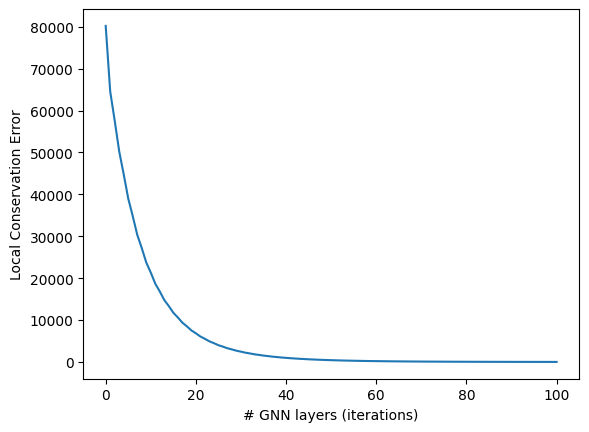

In [28]:
plt.figure()
plt.plot(errors)
plt.xlabel("# GNN layers (iterations)")
plt.ylabel("Local Conservation Error")

Convert the angles from Radian to Degree ($\times \frac{180}{\pi}$)

In [29]:
import math
predictions = predictions * (180/math.pi)

Compute the MAPE metric on voltage angles

In [31]:
MAPE = abs((observations - (predictions)) / (observations + 1e-10)).mean()
print("MAPE: ", MAPE)

MAPE:  tensor(0.0001, device='cuda:0', dtype=torch.float64)


Compute MAPE10 on voltage angles (90% highest quantile of the distribution).

In [32]:
from lips.metrics.ml_metrics.external_metrics import mape_quantile

MAPE_10 = mape_quantile(y_true=observations.detach().cpu(), y_pred=predictions.detach().cpu(), quantile=0.9)
print("MAPE 10: ", MAPE_10)

MAPE 10:  0.0001460746875379807


Once the voltage angles are computed using the model, we can transform them to power flows (active powers) using the provided function `get_all_active_powers`.

In [33]:
import warnings
from utils.graph_utils import get_obs, get_all_active_powers

warnings.filterwarnings("ignore")
env, obs = get_obs(benchmark)
p_ors_pred, p_exs_pred = get_all_active_powers(benchmark._test_dataset.data,
                                               obs,
                                               theta_bus=predictions.view(-1,14).cpu())

  0%|          | 0/10000 [00:00<?, ?it/s]

In [34]:
my_predictions = {}
my_predictions["p_or"] = p_ors_pred
my_predictions["p_ex"] = p_exs_pred

In [35]:
MAPE10_Power = mape_quantile(y_true=benchmark._test_dataset.data["p_or"], 
                             y_pred=my_predictions["p_or"], 
                             quantile=0.9)
print("MAPE10 on Active Powers: ", MAPE10_Power)

MAPE10 on Active Powers:  0.00023004051043067157


### Physics law verification 

Once the power flow is computed from the predicted voltage angles, we can verify the local conservation law using the provided function in LIPS framework. This law is one among 8 physics laws that should be respected in this challenge. 

In [40]:
from lips.metrics.power_grid.local_conservation import local_conservation

LC_tolerance = 1e-2

verification = local_conservation(predictions=my_predictions,
                                  observations=benchmark._test_dataset.data,
                                  tolerance=LC_tolerance,
                                  env=env,
                                  result_level=2)
print(f"Violation percentage: {verification['violation_percentage']:.2f} %")

Violation percentage: 5.28 %
